### Imports

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

from utils import (
    get_mean_interval,
    get_median_interval,
    plot_two_ts,
    get_bland_altman_plot,
    get_mean_error,
    get_mae,
    get_reliability,
    get_cross_correlation_lag
)

### Load data

In [2]:
benchmark_data = pd.read_csv("./data/benchmark_data.csv")

In [3]:
test_data = pd.read_csv("./data/test_data.csv", skiprows=6) # first 6 rows are metadata

C:\Users\Zhenia\AppData\Local\Temp\ipykernel_9340\4171751774.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv("./data/test_data.csv", skiprows=6) # first 6 rows are metadata


### Data preparation

Select necessary columns

In [4]:
benchmark_data_hr = benchmark_data[["Timestamp", "HR"]]
test_data_hr = test_data[["timestamp", "hr"]]

Check data dimensionality and missed values

In [5]:
benchmark_data_hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Timestamp  725 non-null    object
 1   HR         725 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.5+ KB


In [6]:
test_data_hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22403 entries, 0 to 22402
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  22403 non-null  object 
 1   hr         22399 non-null  float64
dtypes: float64(1), object(1)
memory usage: 350.2+ KB


Unify column names

In [7]:
benchmark_data_hr.columns = ["timestamp", "hr"]

Cut invalid data from test data

In [8]:
test_data_hr = test_data_hr[:-4]

Convert time to common format

In [9]:
test_data_hr['timestamp'] = (
    pd.to_datetime(test_data_hr['timestamp'], unit='ms', utc=True)
        .dt.tz_convert("Europe/Kyiv") # localize to benchmark_data_hr timezone
        .dt.tz_localize(None) # remove timezone info
)
benchmark_data_hr['timestamp'] = pd.to_datetime(benchmark_data_hr['timestamp'])

C:\Users\Zhenia\AppData\Local\Temp\ipykernel_9340\2553006962.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  pd.to_datetime(test_data_hr['timestamp'], unit='ms', utc=True)
C:\Users\Zhenia\AppData\Local\Temp\ipykernel_9340\2553006962.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark_data_hr['timestamp'] = pd.to_datetime(benchmark_data_hr['timestamp'])


In [10]:
benchmark_data_hr["timestamp"].head()

0   2025-05-09 11:35:39.372
1   2025-05-09 11:35:40.373
2   2025-05-09 11:35:41.372
3   2025-05-09 11:35:42.372
4   2025-05-09 11:35:43.373
Name: timestamp, dtype: datetime64[ns]

In [11]:
test_data_hr["timestamp"].head()

0   2025-05-09 11:34:14.457676514
1   2025-05-09 11:34:14.497352295
2   2025-05-09 11:34:14.537028564
3   2025-05-09 11:34:14.576704834
4   2025-05-09 11:34:14.616381104
Name: timestamp, dtype: datetime64[ns]

Check data duplicates

In [12]:
print("Benchmark data duplicates:", benchmark_data_hr.duplicated().sum())
print("Test data duplicates:", test_data_hr.duplicated().sum())

Benchmark data duplicates: 0
Test data duplicates: 0


_There are no duplicates in data_

### Data synchronization

Check data time range

In [13]:
print("Benchmarg date range:", benchmark_data_hr['timestamp'].min().time(), " - ", benchmark_data_hr['timestamp'].max().time())
print("Test data date range:", test_data_hr['timestamp'].min().time(), " - ", test_data_hr['timestamp'].max().time())

Benchmarg date range: 11:35:39.372000  -  11:47:43.337000
Test data date range: 11:34:14.457676  -  11:49:17.717000


_The test data covers wider time range._

_Overall, data covers a short period of time._

Check data frequency

In [14]:
print("Benchmark data mean interval:", get_mean_interval(benchmark_data_hr, "timestamp"))
print("Benchmark data median interval:", get_median_interval(benchmark_data_hr, "timestamp"))

Benchmark data mean interval: 0 days 00:00:00.999951657
Benchmark data median interval: 0 days 00:00:01


In [15]:
print("Test data mean interval:", get_mean_interval(test_data_hr, "timestamp"))
print("Test data median interval:", get_median_interval(test_data_hr, "timestamp"))

Test data mean interval: 0 days 00:00:00.040327677
Test data median interval: 0 days 00:00:00.040042480


_The benchmark data has once per second frequency._

_The test data has 25 measurments per second._

_We'll need to resample data._

Plot the data

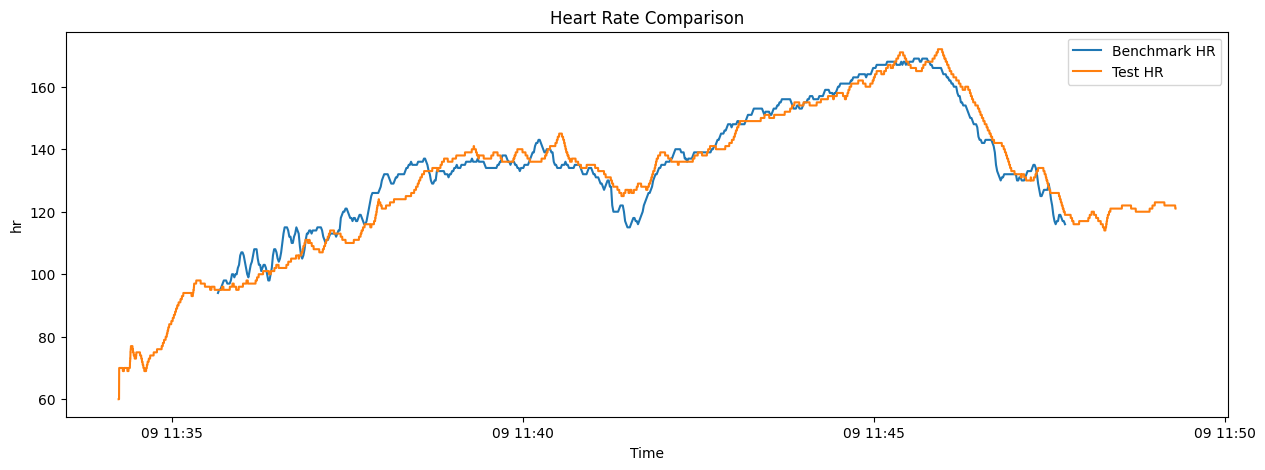

In [16]:
plot_two_ts(
    benchmark_data_hr,
    test_data_hr,
    time_col="timestamp",
    value_col="hr",
    label1="Benchmark HR",
    label2="Test HR",
    title="Heart Rate Comparison",
)

_We visually see worse agreement on the lower HR._

_There is a suspicion of a slight shift in the data._

Check data syncronization with cross-correlation analysis

In [17]:
benchmark_df = benchmark_data_hr.set_index('timestamp').sort_index()
test_df = test_data_hr.set_index('timestamp').sort_index()

time_lag = get_cross_correlation_lag(benchmark_df, test_df)
print(f"Calculated lag is {time_lag:.4f} seconds.")

Calculated lag is 0.0000 seconds.


_The data shift suspicion was not confirmed._

Downsample test data

_For further analysis, we need to bring the data to a uniform sampling frequency. Since the benchmark data have a lower frequency (1 measurement per second), it was decided to **downsample the test data** using **mean aggregation**._

_Firstly, this approach preserves the **integrity of the ground truth data**, and secondly, mean aggregation smooths the test data, thereby **reducing noise** in the dataset._

In [18]:
# Downsample test data to 1 Hz for final comparison
test_data_hr_downsampled = test_data_hr.set_index("timestamp").resample('1s').mean().reset_index()

# Round mean heart rate to nearest integer
test_data_hr_downsampled['hr'] = test_data_hr_downsampled['hr'].round().astype('Int64')

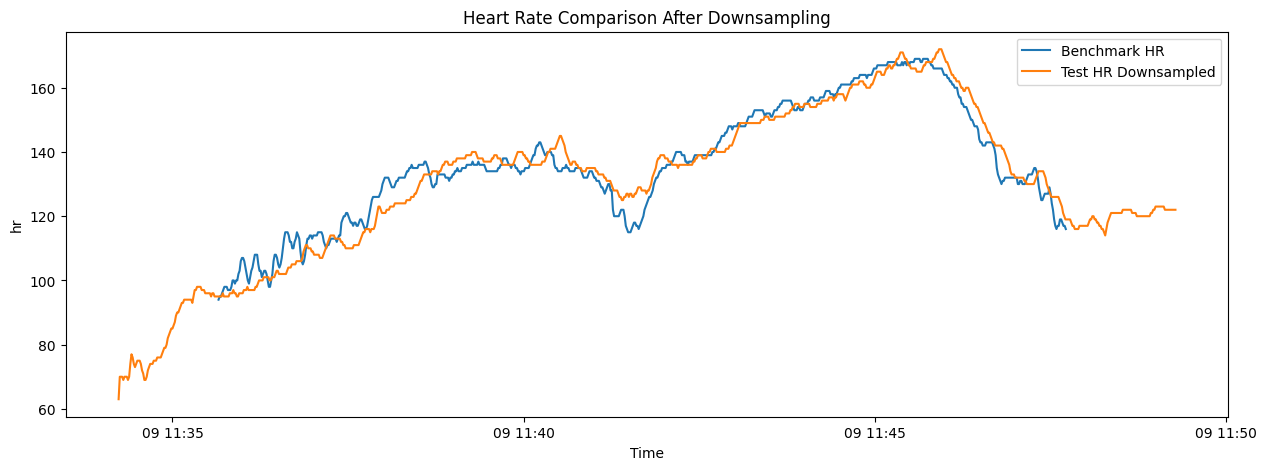

In [19]:
plot_two_ts(
    benchmark_data_hr,
    test_data_hr_downsampled,
    time_col="timestamp",
    value_col="hr",
    label1="Benchmark HR",
    label2="Test HR Downsampled",
    title="Heart Rate Comparison After Downsampling",
)

Allign data by time

In [20]:
benchmark_df = benchmark_data_hr.set_index('timestamp').sort_index()
test_df = test_data_hr_downsampled.set_index('timestamp').sort_index()

benchmark_df.columns = ["benchmark_hr"]
test_df.columns = ["test_hr"]

synchronized_df = pd.merge_asof(
    left=benchmark_df,
    right=test_df,
    left_index=True,
    right_index=True,
    direction='nearest',
    tolerance=pd.Timedelta(seconds=0.5)
)

In [21]:
print("Synchronized data length:", len(synchronized_df))

Synchronized data length: 725


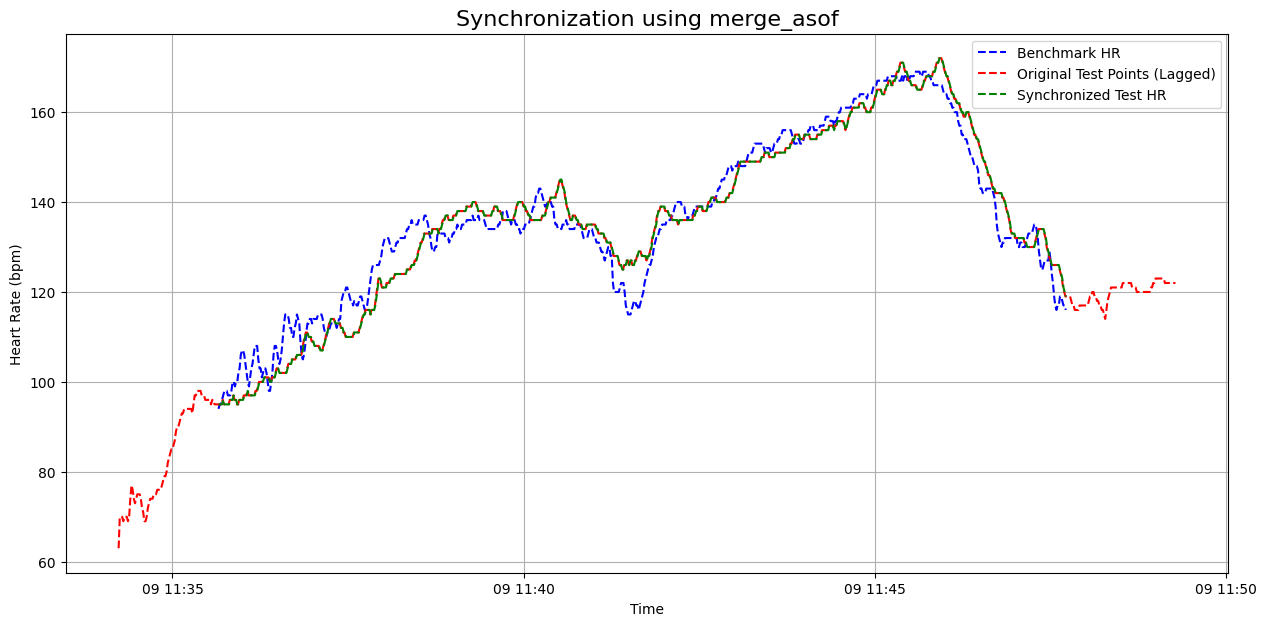

In [22]:
plt.figure(figsize=(15, 7))
plt.title('Synchronization using merge_asof', fontsize=16)

plt.plot(synchronized_df.index, synchronized_df['benchmark_hr'], '--', color='blue', label='Benchmark HR')
plt.plot(test_data_hr_downsampled["timestamp"], test_data_hr_downsampled['hr'], '--', color='red', label='Original Test Points (Lagged)')
plt.plot(synchronized_df.index, synchronized_df['test_hr'], '--', color='green', label='Synchronized Test HR')

plt.legend()
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Heart Rate (bpm)')
plt.show()

### Comparison methodology

_If we wanted to choose the best test device among a group of devices, we could use many relative metrics that can only be evaluated through comparison — for example, **distance metrics** (Euclidean, Manhattan), **correlation coefficient**, **root mean square error**, and others._

_Since in our case we only have a benchmark device and a test device, we should select metrics that are **easy to interpret** and that **align with specific (business) requirements**._

_We take our benchmark device as the ground truth. I propose the following metrics for evaluating the heart rate measurement quality of the test device:_

* _**Bias:** Systematic offset, used to check whether the device tends to systematically overestimate or underestimate values._
* _**MAE (Mean Absolute Error):** Accuracy — shows by how many absolute units the device deviates on average._
* _**Reliability %:** The percentage of time the absolute error is smaller than a given threshold (for example, 10 bpm)._

_I also propose a visual representation of the results using a **Bland–Altman plot**. This is a standard method in medical and biometric research. It visualizes the difference between two measurements against their mean value, allowing one to instantly see both the **average bias** and the **range of errors** (“limits of agreement”)._


Calculate metrics

In [23]:
me = get_mean_error(synchronized_df['benchmark_hr'], synchronized_df['test_hr'])
mae = get_mae(synchronized_df['benchmark_hr'], synchronized_df['test_hr'])
reliability = get_reliability(synchronized_df['benchmark_hr'], synchronized_df['test_hr'], threshold=10)

In [24]:
print(f"Mean Error (ME): {me:.2f} bpm")
print(f"Mean Absolute Error (MAE): {mae:.2f} bpm")
print(f"Reliability (within 10 bpm): {reliability*100:.2f} %")

Mean Error (ME): -0.26 bpm
Mean Absolute Error (MAE): 3.92 bpm
Reliability (within 10 bpm): 96.69 %


Plot Bland-Altman plot

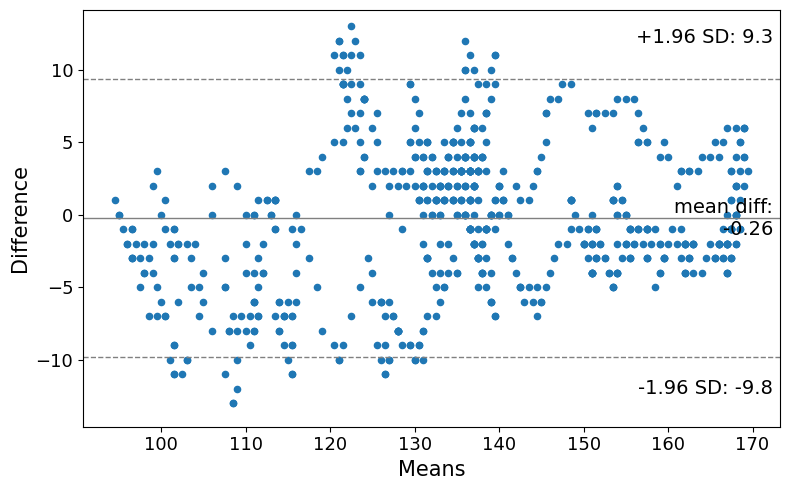

In [25]:
get_bland_altman_plot(synchronized_df['test_hr'], synchronized_df['benchmark_hr'])

### Comparison conclusion

_The following metrics were obtained:_

* _**Bias:** -0.26 bpm_
* _**MAE:** 3.92 bpm_
* _**Reliability (within 10 bpm):** 96.69%_

_From the Bland–Altman plot, it can be seen that the tracker shows lower accuracy (underestimates) at lower heart rates (100–120 bpm) and higher accuracy at higher heart rates (above 120 bpm). We can also see that there are no “extreme” outliers._

---

_Before drawing a conclusion about the result quality, it is necessary to define what a high-quality result means for us. After analyzing several studies, I identified the following criteria:_

* _**MAE < 5 bpm** is considered high measurement accuracy_
* _**Reliability** (typically using a threshold of <10 bpm for non-medical trackers) of **96%** is considered high and comparable to leading market brands (Apple, Samsung, Garmin)_
* _**Bias close to 1.0** indicates strong performance_

---

_Based on these criteria, we can conclude that:_

* _The tracker has almost no systematic measurement error_
* _The tracker demonstrates high average accuracy_
* _The tracker shows high reliability_

_Thus, the proposed test device provides performance comparable to popular commercial devices on the market._

---

_Links_

https://pulseon.com/wp-content/uploads/2021/10/PulseOn-EMBC15-Accuracy-and-Reliability.pdf

https://cdt.amegroups.org/article/view/26754/html

https://www.empirical.health/blog/apple-watch-heart-rate-monitor-accuracy/

https://pubmed.ncbi.nlm.nih.gov/36583938/
